<a href="https://colab.research.google.com/github/khadija-aitmeddour/Flower-Classifier/blob/main/Flower_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing a Flower Image Classifier

In this notebook, we will build a flower image classifier using deep learning techniques. We will use a pre-trained model from PyTorch and fine-tune it to classify images of flowers.

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Loading the Data

We will load the dataset and apply the necessary transformations.

In [2]:
# imports
import os
import requests
from pathlib import Path
import tarfile

# defining dataset directory
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")

    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Directory created: ./flowers

[INFO] Downloading the file 'flower_data.tar.gz' to ./flowers
[INFO] 'flower_data.tar.gz' saved to ./flowers

[INFO] Extracting the downloaded tarball to ./flowers
[INFO] 'flower_data.tar.gz' extracted successfully to ./flowers

[INFO] Deleting the tarball to save space.


## Data Description

The dataset is split into three parts: training, validation, and testing.

In [3]:
data_dir = './flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

## Data Transformations
We will apply transformations to the training and testing datasets.

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])
test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
validset = datasets.ImageFolder(valid_dir, transform=test_transforms)
testset = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

### Label Mapping
We will load a JSON file that maps the category labels to flower names.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and Training the Classifier

## Building the Classifier
We will build the classifier using a pre-trained VGG19 model.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[0].in_features

model.classifier = nn.Sequential(nn.Linear(n_inputs, 512),
                          nn.ReLU(),
                          nn.Linear(512, 102),
                          nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
model.to(device);

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training the Classifier

We will train the classifier using the training dataset and validate it using the validation dataset.

In [17]:
epochs = 5
print('\nTraining in progress...')
print('---------------------------------')
for e in range(epochs):
    model.train()

    running_train_loss = 0
    running_validation_loss = 0
    accuracy = 0
    n_train = len(trainloader)
    n_valid = len(validloader)

    epoch_start = time.time()

    for inputs, labels in trainloader:

        inputs, labels= inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        train_loss = criterion(logps, labels)
        train_loss.backward()
        optimizer.step()

        running_train_loss += train_loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for inputs, labels in validloader:
                inputs, labels= inputs.to(device), labels.to(device)

                logps = model.forward(inputs)
                validation_loss = criterion(logps, labels)

                running_validation_loss += validation_loss

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        avg_train_loss = running_train_loss/n_train
        avg_val_loss = running_validation_loss/n_valid
        avg_val_accuracy = (accuracy/n_valid) *100

        print(f'Epoch {e+1} completed in : {(time.time() - epoch_start):.2f}s')
        print('--------------------------')
        print(f'Training Loss : {avg_train_loss:.4f}')
        print(f'Validation Loss : {avg_val_loss:.4f}')
        print(f'Validation Accuracy : {avg_val_accuracy:.2f}%\n')
print('---------------------------------')
print('Training completed successfully!')


Training in progress...
---------------------------------
Epoch 1 completed in : 82.94s
--------------------------
Training Loss : 2.9877
Validation Loss : 1.4900
Validation Accuracy : 65.52%

Epoch 2 completed in : 82.69s
--------------------------
Training Loss : 1.5786
Validation Loss : 0.8801
Validation Accuracy : 80.97%

Epoch 3 completed in : 82.25s
--------------------------
Training Loss : 1.2064
Validation Loss : 0.7029
Validation Accuracy : 83.33%

Epoch 4 completed in : 82.67s
--------------------------
Training Loss : 1.0025
Validation Loss : 0.5768
Validation Accuracy : 85.08%

Epoch 5 completed in : 82.46s
--------------------------
Training Loss : 0.8866
Validation Loss : 0.5660
Validation Accuracy : 86.40%

---------------------------------
Training completed successfully!


## Testing the Network
We will test the trained model using the test dataset.

In [19]:
accuracy = 0

with torch.no_grad():
    model.eval()

    for inputs, labels in testloader:
        inputs, labels= inputs.to(device), labels.to(device)

        logps = model.forward(inputs)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    print(f'Test accuracy : {(accuracy/len(testloader))*100:.2f}%')

Test accuracy : 82.33%


## Saving the Checkpoint
We will save the trained model checkpoint.

In [21]:
model.class_to_idx = trainset.class_to_idx

checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'test_loss': avg_val_loss,
        'accuracy': avg_val_accuracy
    }
torch.save(checkpoint, 'checkpoint.pth')
print('Checkpoint saved successfully!')

Checkpoint saved successfully!


## Loading the Checkpoint

We will write a function to load a checkpoint and rebuild the model. This is useful in case we need to resume training or use the model later without retraining.

In [ ]:
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    return epoch

# Inference for Classification

## Image Preprocessing

We will preprocess the image for use in the model.

In [22]:
def process_image(image):

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = transform(image)
    image = image.view(1, *image.shape)

    image = image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    return image

## Class Prediction

We will write a function to predict the class of an image using the trained model.

In [13]:
def predict(image_path, model):
    image = Image.open(image_path)
    image = process_image(image)

    logps = model.forward(image)
    ps = torch.exp(logps)
    probs, idx = ps.topk(5, dim=1)

    idx = idx.squeeze().tolist()
    probs = probs.squeeze().tolist()

    idx_to_class = {idx:k for k, idx in model.class_to_idx.items()}

    classes_idx = [idx_to_class[i] for i in idx]
    classes_names = [cat_to_name[c] for c in classes_idx]

    return classes_names, probs

## Sanity Checking



## Visualizing the Predictions

We will visualize the top 5 predictions for a given image along with their probabilities.

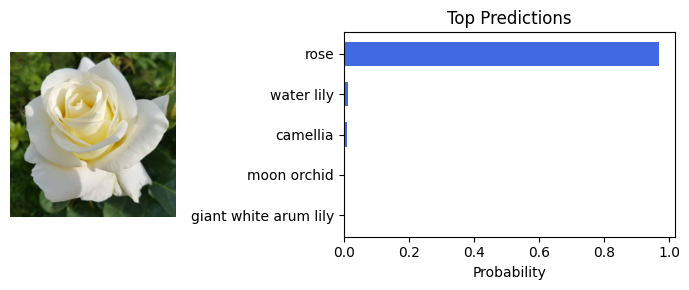

In [23]:
image_path = 'white_rose.jpg'

image = Image.open(image_path)
image.thumbnail((300,300))

classes, probs = predict(image_path, model)

probs, classes = probs[::-1], classes[::-1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(image)
ax[0].axis("off")

ax[1].barh(classes, probs, height=0.6, color="royalblue")
ax[1].set_xlabel("Probability")
ax[1].set_title("Top Predictions")

ax[1].set_xticks(np.arange(0, 1.1, 0.2))

plt.tight_layout()
plt.show()